In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad
from scipy.optimize import minimize

import numpy as np

import arviz as az

import corner
import matplotlib.pyplot as plt
import pandas as pd

from src.likelihood import LogLikelihood
from src.velocity import velocity

import hemcee

/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_88367/1844351846.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "+k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')


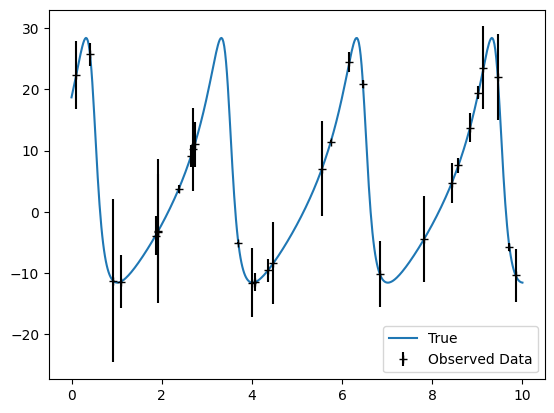

In [82]:
tf = 10
t = jnp.linspace(0, tf, 500)  # 500 time points over 10 days

# Orbital parameters
period = 3.0          # Orbital period in days
eccentricity = 0.50    # Moderate eccentricity (0 <= ecc < 1)
omega = 1.0          # Argument of periastron in radians 
phi0 = 1.0            # Phase offset (in radians)
K = 20.0              # Semi-amplitude of velocity in m/s
v0 = 0.0              # Systemic velocity offset in m/s

initial_params = jnp.array([period, eccentricity, omega, phi0, K, v0])

# True Data
rv_true = velocity(t, period, eccentricity, omega, phi0, K, v0)

# Observed Data
n_observed = 30
time_obs = np.sort(np.random.uniform(0, tf, n_observed))
rv_err = 5 * np.abs(np.random.normal(size=len(time_obs)))
rv_obs = velocity(time_obs, period, eccentricity, omega, phi0, K, v0) 


plt.plot(t, rv_true, label="True ")
plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')
plt.legend(loc='lower right')
plt.show()


In [75]:
loglikelihood = LogLikelihood(times=time_obs, 
                              observed_data=rv_obs, 
                              uncertainity=rv_err, 
                              jitter=0.0)

# Pre-seed Walkers

Let's use `TheJoker` to find solution of high probabilty

In [138]:
import thejoker as tj
import astropy

<Axes: xlabel='time [BMJD]', ylabel='RV [$\\mathrm{km\\,s^{-1}}$]'>

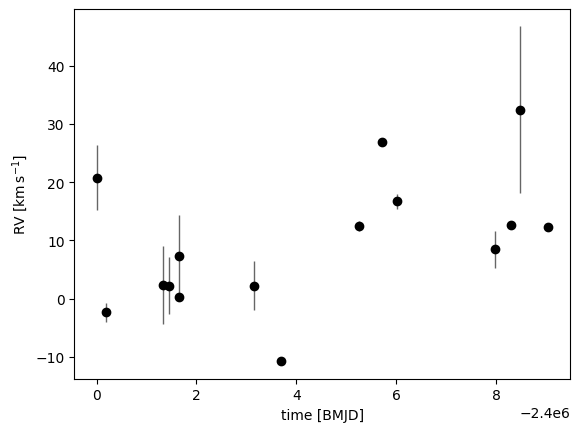

In [139]:
t = astropy.time.Time(time_obs, format="jd", scale="tcb")

data = tj.RVData(
    t=t, 
    rv=rv_obs * u.km/u.s, 
    rv_err=rv_err * u.km/u.s
)
data.plot()

### Construct Prior Smaples

In [146]:
rnd = np.random.default_rng(seed=42)

prior = tj.JokerPrior.default(
    P_min=2*u.day, P_max=256*u.day,
    sigma_K0=30*u.km/u.s,
    sigma_v=100*u.km/u.s
)
prior_samples = prior.sample(size=250_000, rng=rnd)
prior_samples

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "/Users/clarkmiyamoto/miniconda3/envs/thejoker/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "/Users/clarkmiyamoto/miniconda3/envs/thejoker/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/clarkmiyamoto/miniconda3/envs/thejoker/lib/python3.11/importlib/__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


<JokerSamples [e, omega, M0, s, P] (250000 samples)>

### Construct Posterior Samples

In [145]:
joker = tj.TheJoker(prior, rng=rnd)
joker_samples = joker.rejection_sample(data, prior_samples, max_posterior_samples=256 * 2)

In [142]:
joker_samples

<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>

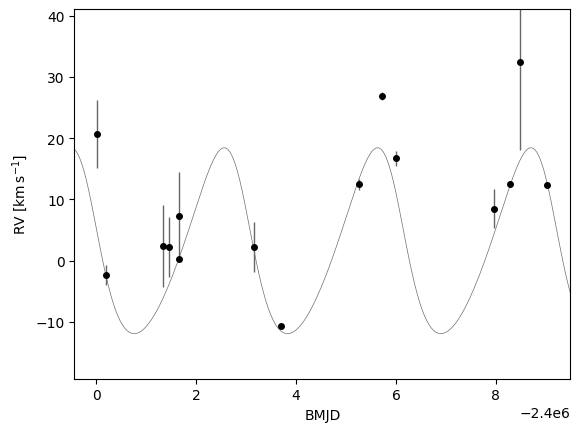

In [143]:
_ = tj.plot_rv_curves(joker_samples, data=data)


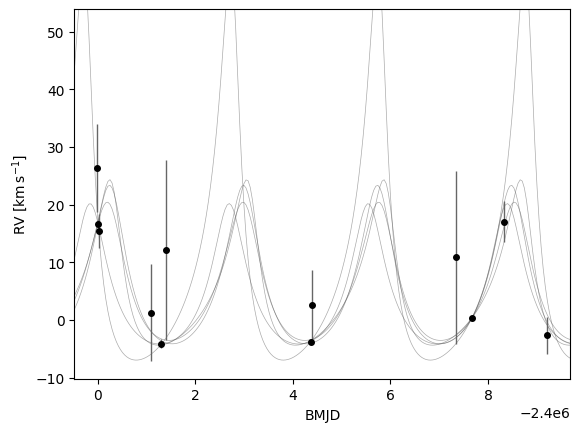

In [101]:
_ = tj.plot_rv_curves(joker_samples, data=data)

# HMC Walk w/ Dual Averaging

In [49]:
hemcee.HamiltonianEnsembleSampler?

Init signature:
hemcee.HamiltonianEnsembleSampler(
    total_chains: 'int',
    dim: 'int',
    log_prob: 'Callable',
    grad_log_prob: 'Callable' = None,
    step_size: 'float' = 0.2,
    L: 'int' = 10,
    move=<function hmc_walk_move at 0x14bee5da0>,
    target_accept: 'float' = 0.8,
    t0: 'float' = 10.0,
    mu: 'float' = 0.05,
    gamma: 'float' = 0.05,
    kappa: 'float' = 0.75,
) -> 'None'
Docstring:      Hamiltonian Ensemble samplers. 
File:           ~/nyu/h-emcee/src/hemcee/sampler.py
Type:           type
Subclasses:     

In [ ]:
total_chains = 6 * 5
dim = 6

sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains = total_chains,
    dim = dim,
    log_prob = lambda x: -1* loglikelihood(x),
    step_size=0.001,
    target_accept = 0.8,
    L = 17,
)

period = 3.0          # Orbital period in days
eccentricity = 0.50    # Moderate eccentricity (0 <= ecc < 1)
omega = 1.0          # Argument of periastron in radians 
phi0 = 1.0            # Phase offset (in radians)
K = 20.0              # Semi-amplitude of velocity in m/s
v0 = 0.0              # Systemic velocity offset in m/s

period = jax.random.uniform(jax.random.PRNGKey(0), shape=(total_chains, 1), minval=2, maxval=5)
eccentricity = jax.random.uniform(jax.random.PRNGKey(1), shape=(total_chains, 1), minval=0.4, maxval=.7)
omega = jax.random.uniform(jax.random.PRNGKey(2), shape=(total_chains, 1), minval=0.5, maxval=1.5) 
phi0 = jax.random.uniform(jax.random.PRNGKey(3), shape=(total_chains, 1), minval=0.7, maxval=1.2)
K = jax.random.uniform(jax.random.PRNGKey(4), shape=(total_chains, 1), minval=17, maxval=24)
v0 = jax.random.uniform(jax.random.PRNGKey(5), shape=(total_chains, 1), minval=-10, maxval=10)

inital_states = jnp.concatenate([period, eccentricity, omega, phi0, K, v0], axis=1)


samples, diagnostics = sampler.run_mcmc(
    key=jax.random.PRNGKey(42),
    initial_state = inital_states,
    num_samples = 1000,
    warmup = int(1e4),
)

diagnostics

Using 30 total chains: Group 1 (15), Group 2 (15)


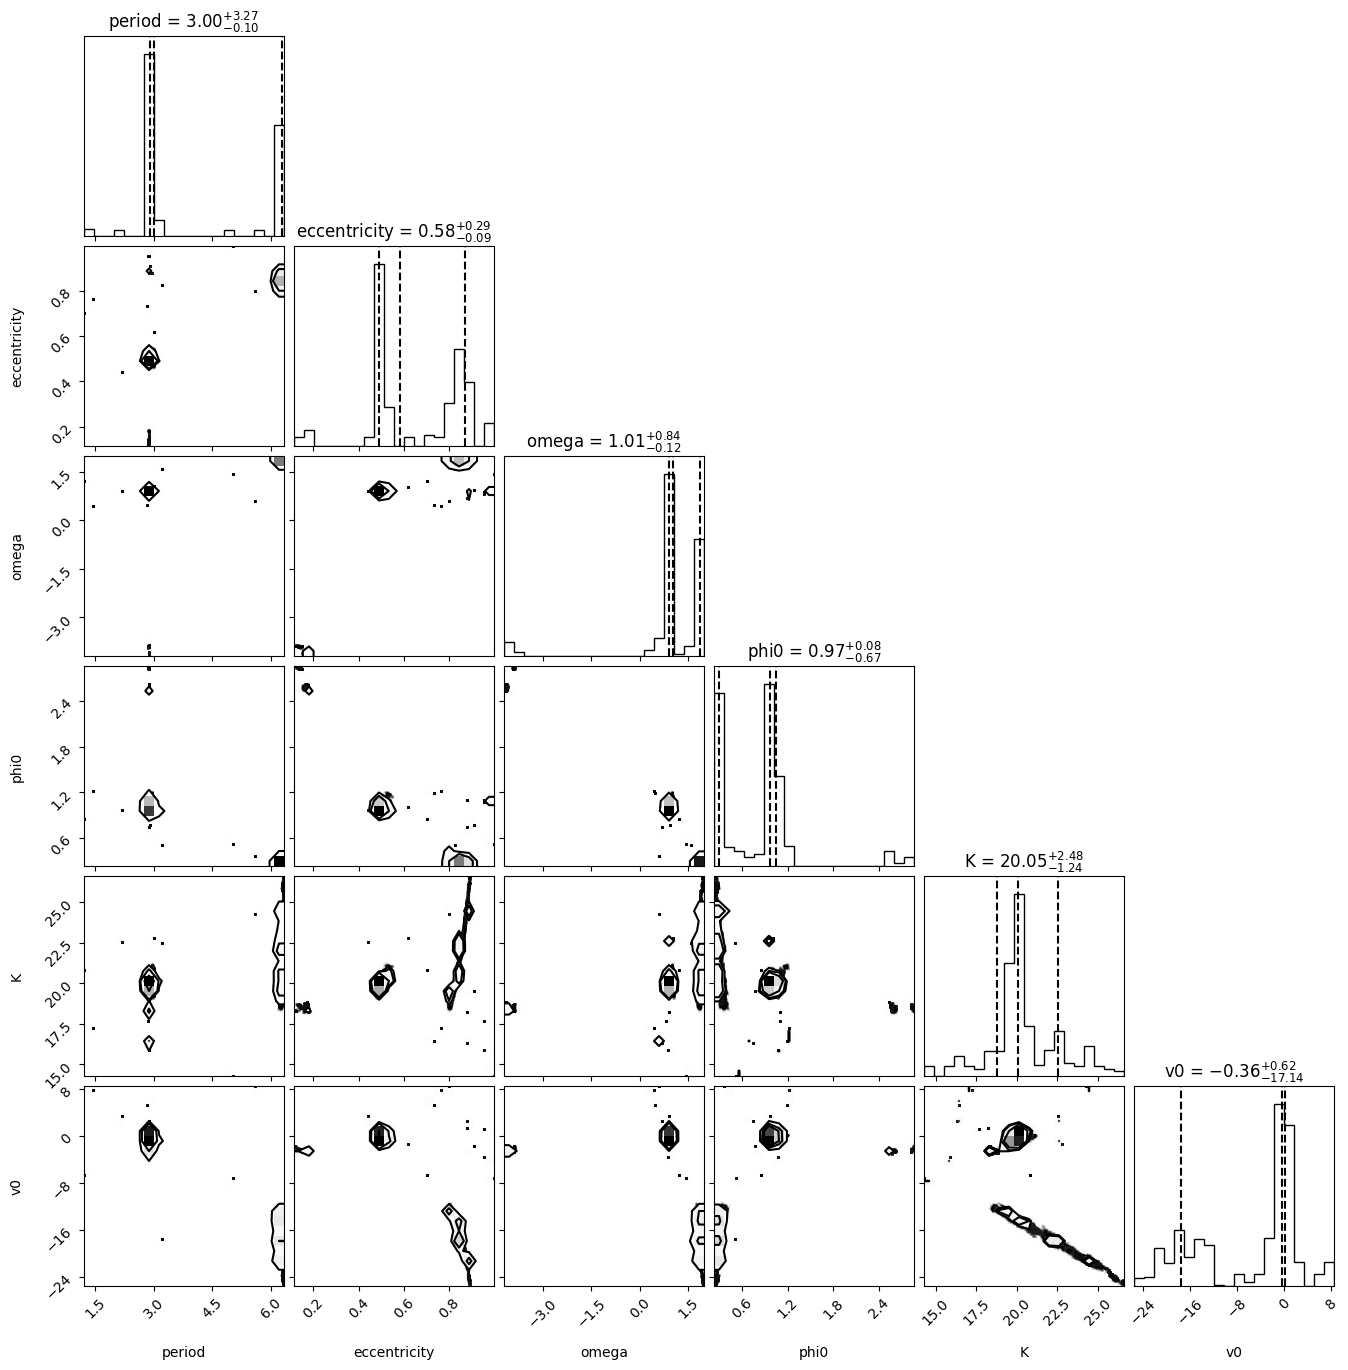

In [91]:
_ = corner.corner(
    np.array(samples.reshape(-1, 6)),
    labels=["period", "eccentricity", "omega", "phi0", "K", "v0"],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
)